In [0]:
# перезагрузить ноутбук
!kill -9 -1



---



---



# Определяет одно выбранное слово. 
Если загруженное слово - одно из списка: 'yes','no','up','down','left','right','stop','go','on','off' - программа должна его опознать: 

My prediction for down.wav is...
down

В противном случае программа должна сказать:

My prediction for bed.wav is...
UNKNOWN 



---
Используется модель '/content/Simple-Speech-Command-Algorithm/models','model1_dr0.25_lr0.1_ra0.hdf5'





---



---



Копирование файлов с Git на локальный диск виртуальной машины - вставка ссылки с гитхаба: 

In [6]:
!git clone https://github.com/smartsinovich/Simple-Audio-Recognition.git

Cloning into 'Simple-Audio-Recognition'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 335 (delta 61), reused 50 (delta 14), pack-reused 215
Receiving objects: 100% (335/335), 5.02 MiB | 17.56 MiB/s, done.
Resolving deltas: 100% (107/107), done.



Final Algorithm

In [0]:
# This algorithm is a simple command recognition algorithm designed to allow hobbyists and students to build a speech recognition
# component into their own projects. This algorithm takes two parameters - a path to an audio file, and an audio file name - and
# returns 1 of 11 classifications based upon the contents of the audio file. 10 of those classifications are simple speech 
# commands - 'yes','no','up','down','left','right','stop','go','on','off' - while the 11th classification is a catchall 'unknown'
# category.

# Valid audio files for this algorithm have a 16000hz sample rate and a maximum duration of 1 second. 
# Audio files are decoded into 16 bit samples.

# The algorithm was trained and tested with 16 bit samples using the Speech Commands Dataset released by Google on August 3, 2017. The 
# data contains 64,727 one-second 16000hz audio clips of 30 short words. The audio files were crowdsourced by Google with the goal 
# of collecting single-word commands (rather than words as said and used in conversation). 

# RUN THIS CELL TO LOAD ALGORITHM INTO IPYTHON KERNEL

import os
from scipy.io import wavfile
from scipy.fftpack import dct
import numpy as np
import keras
import math
from keras.models import load_model

def speech_command_algo(audio_path, filename):
    #print("My prediction for "+filename+" is...")
    model_path = os.path.join(os.path.dirname(os.path.abspath('__file__')),
                              '/content/Simple-Audio-Recognition/Models',
                              'model1_dr0.25_lr0.1_ra0.hdf5')  # путь к модели и модель
    
    
    model = load_model(model_path)
    mfccs = mfcc_conversion(audio_path, filename).reshape((1,79,12))
    prediction = np.argmax(model.predict(mfccs))
    print("My prediction for "+filename+" is...") 
    if prediction == 1:
        prediction = "yes"
    elif prediction == 2:
        prediction = "no"
    elif prediction == 3:
        prediction = "up"
    elif prediction == 4:
        prediction = "down"
    elif prediction == 5:
        prediction = "left"
    elif prediction == 6:
        prediction = "right"
    elif prediction == 7:
        prediction = "on"
    elif prediction == 8:
        prediction = "off"
    elif prediction == 9:
        prediction = "stop"
    elif prediction == 10:
        prediction = "go"
    else:
        prediction = "UNKNOWN"
    print(prediction)
    
# given a filename, mfcc_conversion returns mel frequency cepstral coefficients array
# mfcc_conversion returns array of (79,12) representing 79 audio frames described by 12 coefficients
def mfcc_conversion(audio_path, filename, sample_rate = 16000, frame_size = 400, stride_size = 200, nfft = 512):
    # decode audio
    decoded_audio = audio_decoder(str(os.path.join(audio_path, filename)))    
    audio = decoded_audio.reshape((16000,1))
    
    first_index = 0
    mfcc_coefficients = np.empty((0,12))
    # apply the following for each signal frame
    while first_index <= audio.shape[0]-frame_size:
        last_index = first_index+frame_size
        frame = audio[first_index:last_index,:]
        
        # calculate discrete Fourier transform
        frame = np.fft.fft(frame, n = nfft, axis=0)
        
        # calculate the periodogram estimate of the power spectrum; drop last half of values
        power_spectrum = np.absolute(np.square(frame))/frame_size
        power_spectrum = power_spectrum[0:int(nfft/2),:].astype(float)
        power_spectrum = power_spectrum.reshape((power_spectrum.shape[0],))
        # print(power_spectrum)
        
        # apply the mel filterbank to the power spectra, sum the energy in each filter
            # frequencies on which to define mel filterbanks
        mel_freqs = np.array([300, 383.4, 473.8, 571.7, 677.8, 792.7, 917.3, 1052.2, 1198.3, 1356.7, 1528.3,
                              1714.2, 1915.6, 2133.7, 2370.1, 2626.3, 2903.7, 3204.4, 3530.1, 3882.9, 4265.2,
                              4679.4, 5128.2, 5614.4, 6141.1, 6711.8, 7330.1, 8000]).astype(float)
        vfunc = np.vectorize(bin_index)
        mel_bins = vfunc(mel_freqs, nfft=nfft, sample_rate=16000)
        # print(mel_bins)
        
            # calculate filterbank
        mel_filterbank = np.empty((26,256))
        for i in range(0,mel_filterbank.shape[0]):
            for j in range(0,mel_filterbank.shape[1]):
                mel_bin_min = mel_bins[i]
                mel_bin_mid = mel_bins[i+1]
                mel_bin_max = mel_bins[i+2]
                if j >= mel_bin_min and j < mel_bin_mid:
                    filter = float(j - mel_bin_min) / float(mel_bin_mid - mel_bin_min)
                elif j >= mel_bin_mid and j < mel_bin_max:
                    filter = float(mel_bin_max- j) / float(mel_bin_max - mel_bin_mid)
                else:
                    filter = float(0)
                mel_filterbank[i,j] = filter
                
                # apply filterbank to power spectra and calculate log filterbank energies
        logbankenergies = np.zeros((mel_filterbank.shape[0]))
        for i in range(0, mel_filterbank.shape[0]):
            mel_filters = mel_filterbank[i,:]
            bankenergy = np.dot(power_spectrum,mel_filters)+1
            logbankenergies[i] = np.log(bankenergy)
            
        
        # take the discrete cosine transform of the log filterbank energies
        log_dct = dct(logbankenergies)
        
        # saving DCT coefficients 2-13; discard rest
        log_dct = np.transpose(log_dct[1:13])
        i = first_index/stride_size
        mfcc_coefficients = np.vstack((mfcc_coefficients, log_dct))
                
        # set up next frame
        first_index = first_index + stride_size
    
    return mfcc_coefficients

# calculates bin index given frequency and sample_rate
def bin_index(frequency, nfft=512, sample_rate=16000):
    bin = math.floor((nfft+1)*frequency/sample_rate)
    return bin

# decodes audio given a file name
def audio_decoder(filename):
    rate, data = wavfile.read(filename)
    data = np.array(data)
    if data.shape[0]<=16000:
        difference = 16000 - data.shape[0]
        data = np.append(data,np.zeros((difference,)))
        data = np.transpose(data.reshape((16000,1)))
        data = data.astype(int)
    return data

Number of channels 1
Sample width 2
Frame rate. 16000
Number of frames 16000
parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=16000, comptype='NONE', compname='not compressed')
16000
[0 0 0 ... 0 0 0]


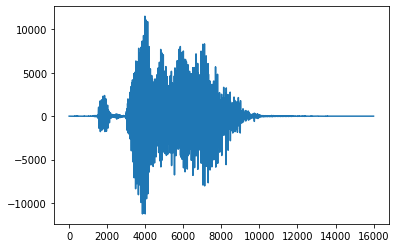

My prediction for mod_s_down.wav is...
down


In [10]:
#USE THIS CELL TO RUN ALGORITHM
## to run, type '
sample_file = 'mod_s_down.wav'
#sample_file = '1_no_bed_bird.wav'
#sample_file = '2_no_bed_bird.wav'
#sample_file = '3_no_bed_bird.wav'
#dir_path = '/content/Simple-Audio-Recognition/Words_from_streams/no_bed_bird'
dir_path = '/content/Simple-Audio-Recognition/MyRawAudio/My_Commands'

#' where
### dir_path is directory path to file
### sample_file is file name

#from scipy.fftpack import fft
#from scipy import signal
from scipy.io import wavfile
import scipy.io.wavfile
import matplotlib.pyplot as plt

import wave
obj = wave.open(dir_path +'/' + sample_file,'r')
print( "Number of channels",obj.getnchannels())
print ( "Sample width",obj.getsampwidth())
print ( "Frame rate.",obj.getframerate())
print ("Number of frames",obj.getnframes())
print ( "parameters:",obj.getparams())
obj.close()


rate, data = scipy.io.wavfile.read(dir_path + '/' + sample_file)
print(rate)
print(data)
plt.plot(data)
plt.show()

speech_command_algo(dir_path,sample_file)



---



---

